# COVID-19 ANALYSIS FOR USA (UNTIL THE END OF APRIL 2020)

#### The aim of this study to provide an overview of the distribution of covid-19 cases and deaths within the US with some visualization techniques. I also applied unsupervised machine learning to cluster the data.

### Import necessary libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup
!pip install lxml

Solving environment: done

# All requested packages already installed.



### Read the Covid-19 data (containing cases and deaths by county and state)

In [98]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [99]:
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [100]:
df.shape

(112572, 6)

In [101]:
df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths      int64
dtype: object

In [102]:
df.isnull().sum()

date         0
county       0
state        0
fips      1317
cases        0
deaths       0
dtype: int64

In [103]:
df = df.drop(['fips'],axis=1)
df.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [104]:
len(df['county'].unique())

1703

In [105]:
len(df['state'].unique())

55

In [106]:
df.describe()

,cases,deaths
count,112572.000000,112572.000000
mean,213.146964,9.707814
std,2453.417285,162.788672
min,0.000000,0.000000
25%,3.000000,0.000000
50%,10.000000,0.000000
75%,45.000000,1.000000
max,174341.000000,13064.000000


### Import census data to get the population per county

In [107]:
df_pop = pd.read_excel('https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx',skiprows=5,header=None,usecols=[0,12])
df_pop.head()

,0,12
0,".Autauga County, Alabama",55869.0
1,".Baldwin County, Alabama",223234.0
2,".Barbour County, Alabama",24686.0
3,".Bibb County, Alabama",22394.0
4,".Blount County, Alabama",57826.0


In [108]:
df_pop = df_pop.rename(columns={0:'County, State',12:'Population Est. 2019'})
df_pop['County, State'] = df_pop['County, State'].str.replace(".","")
df_pop['County'], df_pop['State'] = df_pop['County, State'].str.split(', ',1).str
df_pop.drop(['County, State'],axis=1,inplace=True)
df_pop.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


,Population Est. 2019,County,State
0,55869.0,Autauga County,Alabama
1,223234.0,Baldwin County,Alabama
2,24686.0,Barbour County,Alabama
3,22394.0,Bibb County,Alabama
4,57826.0,Blount County,Alabama


#### Cleaning the data

In [109]:
df_pop.shape

(3148, 3)

In [110]:
df_pop.dtypes

Population Est. 2019    float64
County                   object
State                    object
dtype: object

In [111]:
df_pop.isnull().sum()

Population Est. 2019    6
County                  0
State                   2
dtype: int64

In [112]:
df_popnull = df_pop[pd.isnull(df_pop).any(axis=1)]
df_popnull

,Population Est. 2019,County,State
3142,NaN,Note: The estimates are based on the 2010 Cens...,2010 population due to the Count Question Reso...
3143,NaN,"Note: The 6,222 people in Bedford city","Virginia, which was an independent city as of ..."
3144,NaN,Suggested Citation:,NaN
3145,NaN,Annual Estimates of the Resident Population fo...,"2010 to July 1, 2019 (CO-EST2019-ANNRES)"
3146,NaN,Source: US Census Bureau,Population Division
3147,NaN,Release Date: March 2020,NaN


In [113]:
df_pop.drop(df_pop.index[3142:3148],inplace=True)
df_pop.shape

(3142, 3)

In [114]:
df_pop = df_pop.rename(columns={'County':'county','State':'state'})
df_pop.head()

,Population Est. 2019,county,state
0,55869.0,Autauga County,Alabama
1,223234.0,Baldwin County,Alabama
2,24686.0,Barbour County,Alabama
3,22394.0,Bibb County,Alabama
4,57826.0,Blount County,Alabama


In [115]:
df_pop_bystate = df_pop.groupby('state').sum()['Population Est. 2019']
df_pop_bystate = df_pop_bystate.to_frame()
df_pop_bystate.reset_index(inplace=True)
df_pop_bystate.head()

,state,Population Est. 2019
0,Alabama,4903185.0
1,Alaska,731545.0
2,Arizona,7278717.0
3,Arkansas,3017804.0
4,California,39512223.0


### Merge the population and COVID-19 datasets - by state

In [116]:
df2 = df.groupby('state').sum()['cases']
df3 = df.groupby('state').sum()['deaths']
df_bystate = pd.concat([df2, df3], axis=1)
df_bystate.reset_index(inplace=True)
df_bystate.head()

,state,cases,deaths
0,Alabama,154092,4953
1,Alaska,10173,202
2,Arizona,160499,5978
3,Arkansas,68166,1274
4,California,1082445,37887


In [117]:
df_bystate.shape

(55, 3)

In [118]:
df_bystate = pd.merge(df_bystate, df_pop_bystate, on='state')
df_bystate.head()

,state,cases,deaths,Population Est. 2019
0,Alabama,154092,4953,4903185.0
1,Alaska,10173,202,731545.0
2,Arizona,160499,5978,7278717.0
3,Arkansas,68166,1274,3017804.0
4,California,1082445,37887,39512223.0


In [119]:
df_bystate.shape

(51, 4)

### Calculate the cases and deaths per 1.000 population by state

In [120]:
df_bystate['Pop/1000']=df_bystate['Population Est. 2019'].div(1000)
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000
0,Alabama,154092,4953,4903185.0,4903.185
1,Alaska,10173,202,731545.0,731.545
2,Arizona,160499,5978,7278717.0,7278.717
3,Arkansas,68166,1274,3017804.0,3017.804
4,California,1082445,37887,39512223.0,39512.223


In [121]:
df_bystate['Cases/1000']=df_bystate['cases'].div(df_bystate['Pop/1000'])
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000
0,Alabama,154092,4953,4903185.0,4903.185,31.426919
1,Alaska,10173,202,731545.0,731.545,13.906185
2,Arizona,160499,5978,7278717.0,7278.717,22.050452
3,Arkansas,68166,1274,3017804.0,3017.804,22.587948
4,California,1082445,37887,39512223.0,39512.223,27.395194


In [122]:
df_bystate['Deaths/1000']=df_bystate['deaths'].div(df_bystate['Pop/1000'])
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000
0,Alabama,154092,4953,4903185.0,4903.185,31.426919,1.010160
1,Alaska,10173,202,731545.0,731.545,13.906185,0.276128
2,Arizona,160499,5978,7278717.0,7278.717,22.050452,0.821299
3,Arkansas,68166,1274,3017804.0,3017.804,22.587948,0.422161
4,California,1082445,37887,39512223.0,39512.223,27.395194,0.958868


### Get the state centroid location data applying web scraping techniques for further visualizations on maps

In [123]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_geographic_centers_of_the_United_States').text
soup = BeautifulSoup(source, 'html.parser')

In [124]:
My_table = soup.find_all('table',{'class':'wikitable sortable'})[1]

In [125]:
tableheader = My_table.find_all('th')
tableheader

[<th>State or<br/>federal district
 </th>,
 <th>Location
 </th>,
 <th>Coordinates
 </th>]

In [126]:
table_rows = My_table.find_all('tr')
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])
df_stateloc = pd.DataFrame(data)
df_stateloc.drop([0],inplace=True)
df_stateloc.drop([1],axis=1,inplace=True)
df_stateloc = df_stateloc.rename(columns={0:'state',2:'coordinates'})
df_stateloc.head()

,state,coordinates
1,Alabama,32°46′46″N 86°49′43″W﻿ / ﻿32.7794°N 86.8287°W﻿...
2,Alaska,64°04′07″N 152°16′42″W﻿ / ﻿64.0685°N 152.2782°...
3,Arizona,34°16′28″N 111°39′37″W﻿ / ﻿34.2744°N 111.6602°...
4,Arkansas,34°53′38″N 92°26′33″W﻿ / ﻿34.8938°N 92.4426°W﻿...
5,California,37°11′03″N 119°28′11″W﻿ / ﻿37.1841°N 119.4696°...


In [127]:
df_bystate = pd.merge(df_bystate, df_stateloc, on='state')

In [128]:
df_bystate.shape

(51, 8)

In [129]:
df_bystate['c1'], df_bystate['c2'] = df_bystate['coordinates'].str.split(' / ',1).str
df_bystate.drop(['coordinates'],axis=1,inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [130]:
df_bystate.drop(['c1'],axis=1,inplace=True)

In [131]:
df_bystate['c3'], df_bystate['c4'] = df_bystate['c2'].str.split(' / ',1).str

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [132]:
df_bystate.drop(['c2','c3'],axis=1,inplace=True)

In [133]:
df_bystate['latitude'], df_bystate['longitude'] = df_bystate['c4'].str.split(' ',1).str
df_bystate.drop(['c4'],axis=1,inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [134]:
df_bystate['longitude2'], df_bystate['longitude_text'] = df_bystate['longitude'].str.split(' ',1).str
df_bystate.drop(['longitude_text','longitude'],axis=1,inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [135]:
df_state = df_bystate.copy()
df_state = df_state.rename(columns={'longitude2':'longitude'})
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,154092,4953,4903185.0,4903.185,31.426919,1.010160,32.7794;,-86.8287﻿
1,Alaska,10173,202,731545.0,731.545,13.906185,0.276128,64.0685;,-152.2782﻿
2,Arizona,160499,5978,7278717.0,7278.717,22.050452,0.821299,34.2744;,-111.6602﻿
3,Arkansas,68166,1274,3017804.0,3017.804,22.587948,0.422161,34.8938;,-92.4426﻿
4,California,1082445,37887,39512223.0,39512.223,27.395194,0.958868,37.1841;,-119.4696﻿


In [136]:
df_state.dtypes

state                    object
cases                     int64
deaths                    int64
Population Est. 2019    float64
Pop/1000                float64
Cases/1000              float64
Deaths/1000             float64
latitude                 object
longitude                object
dtype: object

In [137]:
df_state['latitude']=df_state['latitude'].astype('str')
df_state['latitude']=df_state['latitude'].str.replace(";","")
df_state['longitude']=df_state['longitude'].astype('str')
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,154092,4953,4903185.0,4903.185,31.426919,1.010160,32.7794,-86.8287﻿
1,Alaska,10173,202,731545.0,731.545,13.906185,0.276128,64.0685,-152.2782﻿
2,Arizona,160499,5978,7278717.0,7278.717,22.050452,0.821299,34.2744,-111.6602﻿
3,Arkansas,68166,1274,3017804.0,3017.804,22.587948,0.422161,34.8938,-92.4426﻿
4,California,1082445,37887,39512223.0,39512.223,27.395194,0.958868,37.1841,-119.4696﻿


In [138]:
df_state['latitude'] = pd.to_numeric(df_state['latitude'], errors='coerce')
df_state['longitude'] = df_state['longitude'].str.replace('\ufeff', '').astype('float')
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,154092,4953,4903185.0,4903.185,31.426919,1.010160,32.7794,-86.8287
1,Alaska,10173,202,731545.0,731.545,13.906185,0.276128,64.0685,-152.2782
2,Arizona,160499,5978,7278717.0,7278.717,22.050452,0.821299,34.2744,-111.6602
3,Arkansas,68166,1274,3017804.0,3017.804,22.587948,0.422161,34.8938,-92.4426
4,California,1082445,37887,39512223.0,39512.223,27.395194,0.958868,37.1841,-119.4696


In [139]:
lat_us = 39.8333333
lon_us = -98.585522
print('The geographical coordinates of US are {}, {}'.format(lat_us, lon_us))

The geographical coordinates of US are 39.8333333, -98.585522


### Visualize the cases per 1.000 population by state
The bigger the radius of the circle the higher is the ratio in the population

In [140]:
map_us_cases1000 = folium.Map(location=[lat_us, lon_us], zoom_start=5)

# add markers to map
for lat, lng, case1000, state in zip(df_state['latitude'], df_state['longitude'], df_state['Cases/1000'],df_state['state'] ):
    label = '{}{}{}'.format(case1000,' ',state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=case1000/4,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(map_us_cases1000)  
    
map_us_cases1000

### Import US states boundaries from GeoJSON file to visualize the data with folium in another way

In [141]:
import os
state_geo = os.path.join('https://raw.githubusercontent.com/shawnbot/topogram/master/data/us-states.geojson')

In [142]:
m = folium.Map(location=[37, -102], zoom_start=5)

In [143]:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df_state,
 columns=['state', 'Cases/1000'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Cases for 1.000 population'
)
folium.LayerControl().add_to(m)
m

### Plotting the distribution of the cases for 1.000 population by using boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcb383e5c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcb38410390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcb383e5b00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcb38410a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcb38410d68>],
 'means': []}

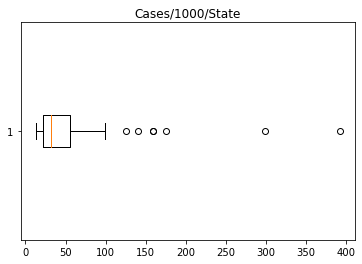

In [144]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cases/1000/State')
ax1.boxplot(df_state['Cases/1000'],vert=False)

### Visualize the deaths per 1.000 population by state
The bigger the radius of the circle the higher is the ratio in the population

In [145]:
map_us_deaths1000 = folium.Map(location=[lat_us, lon_us], zoom_start=5)

# add markers to map
for lat, lng, death1000, state in zip(df_state['latitude'], df_state['longitude'], df_state['Deaths/1000'],df_state['state']):
    label = '{}{}{}'.format(death1000,' ',state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=death1000*5,
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.5,
        parse_html=False).add_to(map_us_deaths1000)  
    
map_us_deaths1000

### Import US states boundaries from GeoJSON file to visualize the deaths with folium in another way

In [146]:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df_state,
 columns=['state', 'Deaths/1000'],
 key_on='feature.properties.name',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Deaths for 1.000 population'
)
folium.LayerControl().add_to(m)
m

### Plotting the distribution of the deaths for 1.000 population by using boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcb30138780>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcb30138e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcb30138470>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcb302b04e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcb302b0828>],
 'means': []}

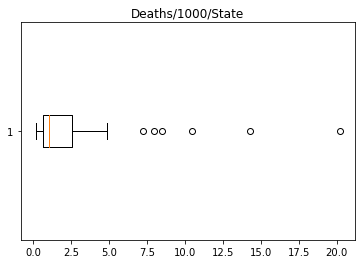

In [147]:
fig1, ax1 = plt.subplots()
ax1.set_title('Deaths/1000/State')
ax1.boxplot(df_state['Deaths/1000'],vert=False)

### Visualize the total cases per county on choropleth map

In [148]:
df_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df_county = df_county.drop(['date','state','fips'],axis=1)
df_county.head()

,county,cases,deaths
0,Snohomish,1,0
1,Snohomish,1,0
2,Snohomish,1,0
3,Cook,1,0
4,Snohomish,1,0


In [149]:
df_county = df_county.groupby(['county']).sum()
df_county.reset_index(inplace=True)
df_county.head()

,county,cases,deaths
0,Abbeville,557,0
1,Acadia,3551,191
2,Accomack,2964,44
3,Ada,18365,333
4,Adair,3173,208


In [150]:
df_county['cases'].max()

4217795

In [151]:
df_county.dtypes

county    object
cases      int64
deaths     int64
dtype: object

In [152]:
df_county['county'] = df_county['county'].astype(str)

#### Import boundaries of counties from JSON file

In [153]:
county_geo = os.path.join('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_500k.json')
m = folium.Map(location=[37, -102], zoom_start=5)

In [154]:
df_county['deathRate']=df_county['deaths']/df_county['cases']
df_county.head()

,county,cases,deaths,deathRate
0,Abbeville,557,0,0.000000
1,Acadia,3551,191,0.053788
2,Accomack,2964,44,0.014845
3,Ada,18365,333,0.018132
4,Adair,3173,208,0.065553


In [155]:
df_county.dtypes

county        object
cases          int64
deaths         int64
deathRate    float64
dtype: object

bins = list(df_county['deathRate'].quantile([0.25, 0.5, 0.75, 1]))

m.choropleth(
 geo_data=county_geo,
 name='choropleth',
 data=df_county,
 columns=['county', 'deathRate'],
 key_on='feature.properties.NAME',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Death Rate by county',
 threshold_scale = bins,
 reset=True
)

folium.LayerControl().add_to(m)

m

### Plotting the total number of cases and deaths

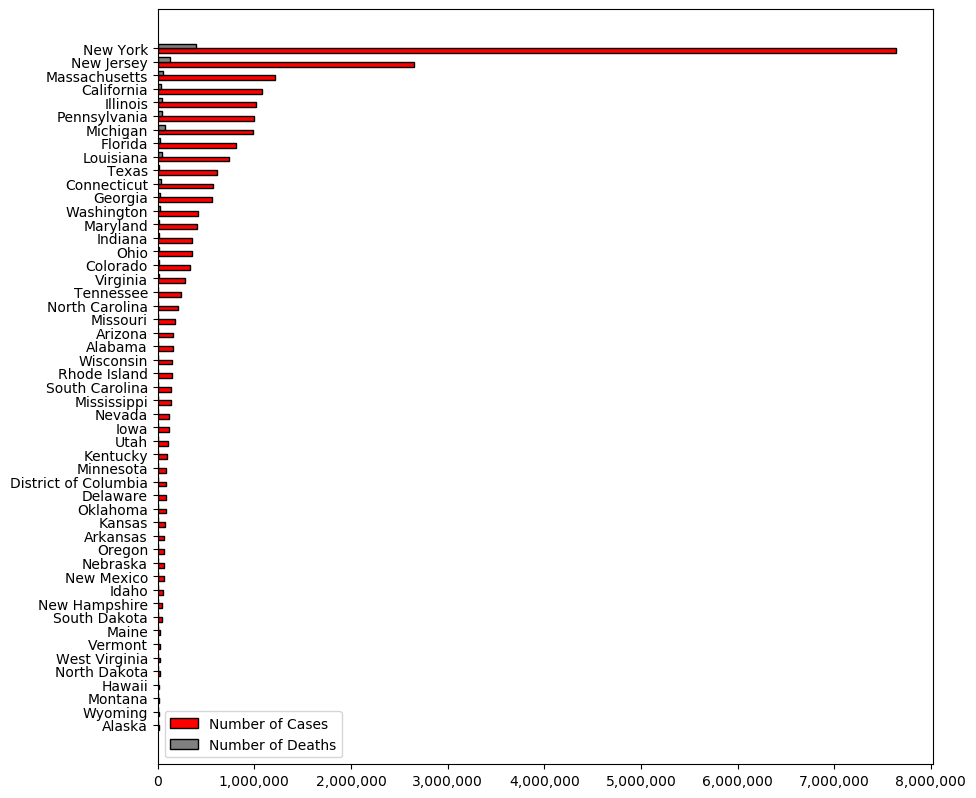

In [156]:
df_state = df_state.sort_values(by='cases')

import matplotlib
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
    
width = 0.35
ind = np.arange(len(df_state))

ax.barh(ind,df_state['cases'],width,color='red',edgecolor='black',label='Number of Cases')
ax.barh(ind+width,df_state['deaths'],width,color='grey',edgecolor='black',label='Number of Deaths')

ax.set_yticks(ind+width/2)
ax.set_yticklabels(df_state['state'])
ax.legend(loc='best')

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

### As the deaths are way outnumbered by cases, the above figure is not the best choice, so I plotted only the total number of deaths below

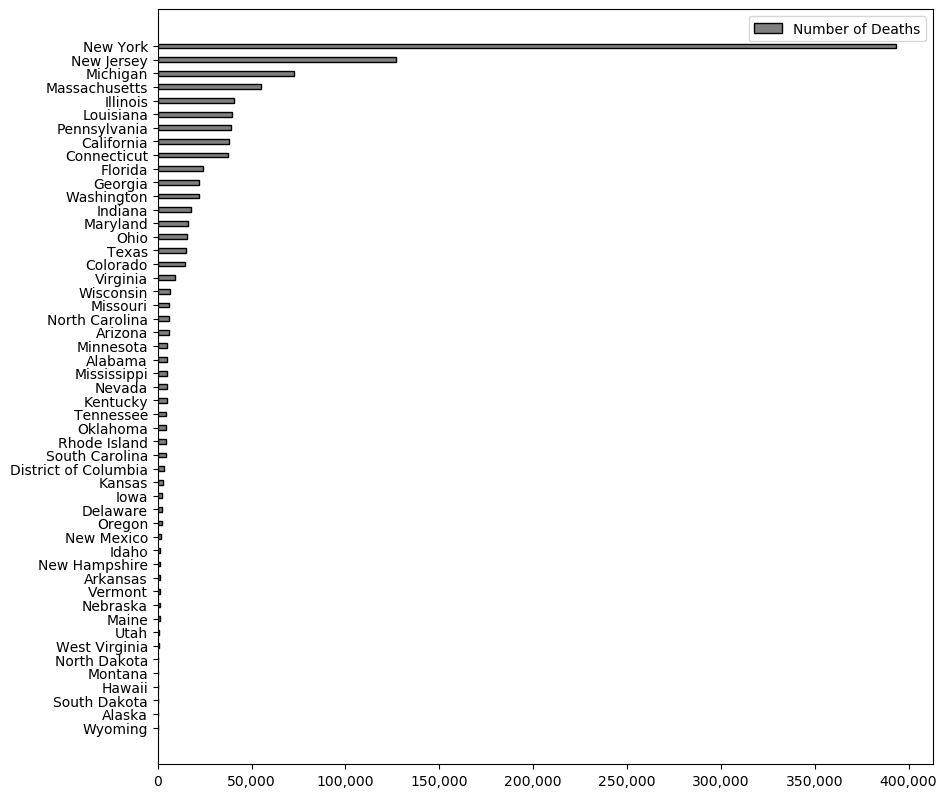

In [157]:
df_state = df_state.sort_values(by='deaths')

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
    
width = 0.35
ind = np.arange(len(df_state))

ax.barh(ind,df_state['deaths'],width,color='grey',edgecolor='black',label='Number of Deaths')

ax.set_yticks(ind)
ax.set_yticklabels(df_state['state'])
ax.legend(loc='best')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

### Plotting the deaths per cases

In [158]:
df_state['deathRate']=df_state['deaths']/df_state['cases']
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude,deathRate
50,Wyoming,10600,103,578759.0,578.759,18.315050,0.177967,42.9957,-107.5512,0.009717
1,Alaska,10173,202,731545.0,731.545,13.906185,0.276128,64.0685,-152.2782,0.019856
41,South Dakota,44697,296,884659.0,884.659,50.524552,0.334592,44.4443,-100.2263,0.006622
11,Hawaii,18295,323,1415872.0,1415.872,12.921366,0.228128,20.2927,-156.3737,0.017655
26,Montana,14102,338,1068778.0,1068.778,13.194508,0.316249,47.0527,-109.6333,0.023968


In [159]:
df_state = df_state.sort_values(by='deathRate')

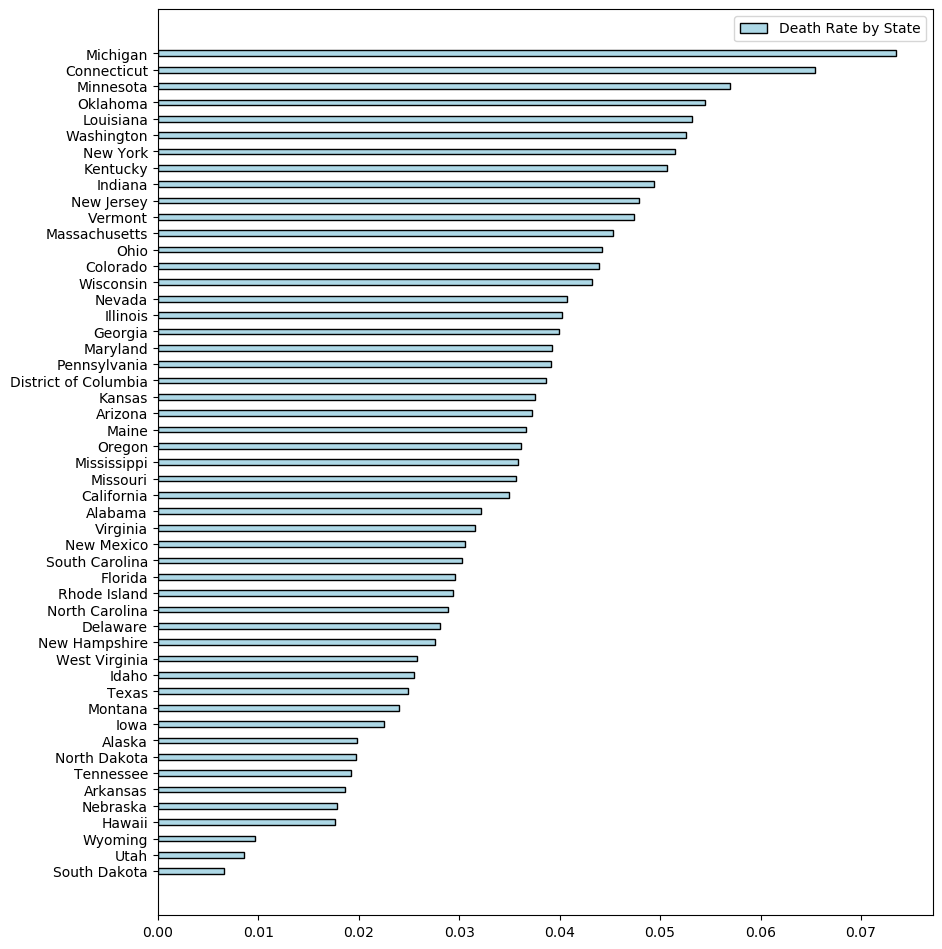

In [160]:
fig, ax = plt.subplots(figsize=(10,12),dpi=100)
    
width = 0.35
ind = np.arange(len(df_state))

ax.barh(ind,df_state['deathRate'],width,color='lightblue',edgecolor='black',label='Death Rate by State')

ax.set_yticks(ind)
ax.set_yticklabels(df_state['state'])
ax.legend(loc='best')

plt.show()

### Applying unsupervised machine learning technique "K-Means" for clustering the data

In [190]:
#creating a dataframe just for the clustering (we need only numbers)
df_clusters = df_state[['Cases/1000','Deaths/1000']]
df_clusters.head()

,Cases/1000,Deaths/1000
41,50.524552,0.334592
44,32.089628,0.275113
50,18.315050,0.177967
11,12.921366,0.228128
27,32.360805,0.576404


In [191]:
df_clusters.describe()

,Cases/1000,Deaths/1000
count,51.000000,51.000000
mean,59.387710,2.501188
std,71.476911,3.793359
min,12.921366,0.177967
25%,22.319200,0.625931
50%,32.360805,1.019808
75%,55.994710,2.575395
max,392.614288,20.214294


In [192]:
#Preprocessing of the data by scaling with Standard Scaler method
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[-0.12523415, -0.57683822],
       [-0.38571492, -0.59267412],
       [-0.58034619, -0.61853839],
       [-0.65655757, -0.60518344],
       [-0.38188326, -0.51245789],
       [-0.51997123, -0.55352367],
       [-0.34773515, -0.48759895],
       [-0.485566  , -0.53420806],
       [-0.64264233, -0.59240385],
       [-0.33657326, -0.45310072],
       [-0.65269814, -0.58172194],
       [-0.54229621, -0.5267115 ],
       [-0.4283497 , -0.46881653],
       [-0.63639742, -0.56727664],
       [-0.35820407, -0.41587432],
       [ 0.38744888, -0.01655983],
       [-0.55479589, -0.51094419],
       [ 1.14773357,  0.43613061],
       [-0.30427191, -0.36794141],
       [-0.45781195, -0.44827181],
       [-0.41785454, -0.42352818],
       [-0.36867687, -0.38587691],
       [-0.39507882, -0.39697393],
       [-0.45204608, -0.41062997],
       [-0.43550005, -0.39440508],
       [-0.1852474 , -0.22444305],
       [-0.62807495, -0.52199719],
       [-0.54537754, -0.4629037 ],
       [-0.52756591,

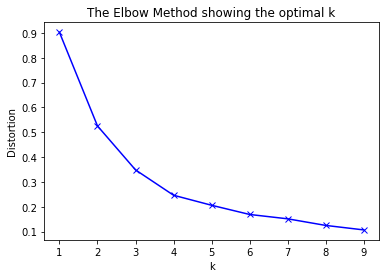

In [193]:
#using Elbow method in order to define optimal k value for clusterint (k will be the number of clusters)
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [194]:
# set number of clusters based on the largest shift on the line (k should be 2)
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:51]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0], dtype=int32)

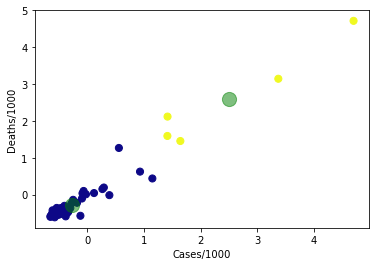

In [195]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5);
plt.xlabel('Cases/1000')
plt.ylabel('Deaths/1000')
plt.show()

In [200]:
df_clustering = df_state.copy()

In [201]:
df_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
df_clustering.head()

,Cluster Labels,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude,deathRate
41,0,South Dakota,44697,296,884659.0,884.659,50.524552,0.334592,44.4443,-100.2263,0.006622
44,0,Utah,102878,882,3205958.0,3205.958,32.089628,0.275113,39.3055,-111.6703,0.008573
50,0,Wyoming,10600,103,578759.0,578.759,18.315050,0.177967,42.9957,-107.5512,0.009717
11,0,Hawaii,18295,323,1415872.0,1415.872,12.921366,0.228128,20.2927,-156.3737,0.017655
27,0,Nebraska,62599,1115,1934408.0,1934.408,32.360805,0.576404,41.5378,-99.7951,0.017812


In [204]:
df_clustering[(df_clustering['Cluster Labels']==1)]

,Cluster Labels,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude,deathRate
21,1,Massachusetts,1210886,54859,6892503.0,6892.503,175.681607,7.959228,42.2596,-71.8083,0.045305
30,1,New Jersey,2650357,127087,8882190.0,8882.190,298.390037,14.308070,40.1907,-74.6728,0.047951
32,1,New York,7637746,393240,19453561.0,19453.561,392.614288,20.214294,42.9538,-75.5268,0.051486
18,1,Louisiana,741267,39394,4648794.0,4648.794,159.453613,8.474026,31.0689,-91.9968,0.053144
6,1,Connecticut,569160,37255,3565287.0,3565.287,159.639322,10.449369,41.6219,-72.7273,0.065456


### Creating a racing bar plot

In [71]:
dff = df.copy()
dff.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [72]:
dff.dtypes

date      object
county    object
state     object
cases      int64
deaths     int64
dtype: object

In [73]:
dff_state = dff[['state','date','cases']]
dff_state.head()

,state,date,cases
0,Washington,2020-01-21,1
1,Washington,2020-01-22,1
2,Washington,2020-01-23,1
3,Illinois,2020-01-24,1
4,Washington,2020-01-24,1


In [74]:
dff_state = dff_state.groupby(['state','date']).count()
dff_state.head()

cases
state   date             
Alabama 2020-03-13      5
        2020-03-14      6
        2020-03-15      8
        2020-03-16      8
        2020-03-17     10

In [75]:
dff_state = dff_state.reset_index()
dff_state.head()

,state,date,cases
0,Alabama,2020-03-13,5
1,Alabama,2020-03-14,6
2,Alabama,2020-03-15,8
3,Alabama,2020-03-16,8
4,Alabama,2020-03-17,10


In [84]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
dff_state1 = dff_state.set_index(['state'])

In [85]:
dummies = pd.get_dummies(dff_state1['date'])
dummies.values[dummies != 0] = dff_state1['cases']
dummies = dummies.groupby(['state']).sum()
dummies.head()

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,8,8,10,12,15,20,21,21,24,26,41,48,53,54,55,59,59,62,63,65,66,66,66,65,66,66,66,66,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,8,8,8,8,9,10,11,10,10,11,11,11,11,12,13,13,13,13,13,13,13,13,13,13,14,14,14,14
Arizona,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,3,4,4,4,5,6,8,9,11,11,11,11,11,13,13,14,14,15,15,15,15,16,16,16,16,16,15,15,16,16,16,16,16,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Arkansas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,4,8,8,11,26,27,27,27,27,39,40,44,45,45,50,52,54,56,60,62,63,65,69,69,70,70,71,71,71,72,72,72,72,72,72,72,72,72,72,73,73,73,73,73,74,74
California,0,0,0,0,1,2,2,2,2,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,7,7,7,8,8,11,11,11,11,12,14,15,15,15,16,20,20,21,23,24,25,26,27,29,30,32,33,33,35,39,40,40,43,45,45,47,48,49,50,51,51,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,53,53,53,54,54,54


In [86]:
dummies = dummies.reset_index()
dummies.head()

,state,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,8,8,10,12,15,20,21,21,24,26,41,48,53,54,55,59,59,62,63,65,66,66,66,65,66,66,66,66,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
1,Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,8,8,8,8,9,10,11,10,10,11,11,11,11,12,13,13,13,13,13,13,13,13,13,13,14,14,14,14
2,Arizona,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,3,4,4,4,5,6,8,9,11,11,11,11,11,13,13,14,14,15,15,15,15,16,16,16,16,16,15,15,16,16,16,16,16,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
3,Arkansas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,4,8,8,11,26,27,27,27,27,39,40,44,45,45,50,52,54,56,60,62,63,65,69,69,70,70,71,71,71,72,72,72,72,72,72,72,72,72,72,73,73,73,73,73,74,74
4,California,0,0,0,0,1,2,2,2,2,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,7,7,7,8,8,11,11,11,11,12,14,15,15,15,16,20,20,21,23,24,25,26,27,29,30,32,33,33,35,39,40,40,43,45,45,47,48,49,50,51,51,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,53,53,53,54,54,54


In [87]:
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.colors as mc
import colorsys
from random import randint
import re

In [88]:
for p in range(3):
    i = 0
    while i < len(dummies.columns):
        try:
            a = np.array(dummies.iloc[:, i + 1])
            b = np.array(dummies.iloc[:, i + 2])
            c = (a + b) / 2
            dummies.insert(i+2, str(dummies.iloc[:, i + 1].name) + '^' + str(len(dummies.columns)), c)
        except:
            print(f"\n  Interpolation No. {p + 1} done...")
        i += 2

dummies = pd.melt(dummies, id_vars = 'state', var_name = 'date')


  Interpolation No. 1 done...

  Interpolation No. 2 done...

  Interpolation No. 3 done...


In [93]:
dummies.head()

,state,date,value
0,Alabama,2020-01-21,0.0
1,Alaska,2020-01-21,0.0
2,Arizona,2020-01-21,0.0
3,Arkansas,2020-01-21,0.0
4,California,2020-01-21,0.0


In [94]:
frames_list = dummies['date'].unique().tolist()
for i in range(10):
    frames_list.append(dummies['date'].iloc[-1])

In [95]:
def transform_color(color, amount = 0.5):

    try:
        c = mc.cnames[color]
    except:
        c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

all_names = dummies['state'].unique().tolist()
random_hex_colors = []
for i in range(len(all_names)):
    random_hex_colors.append('#' + '%06X' % randint(0, 0xFFFFFF))

rgb_colors = [transform_color(i, 1) for i in random_hex_colors]
rgb_colors_opacity = [rgb_colors[x] + (0.825,) for x in range(len(rgb_colors))]
rgb_colors_dark = [transform_color(i, 1.12) for i in random_hex_colors]

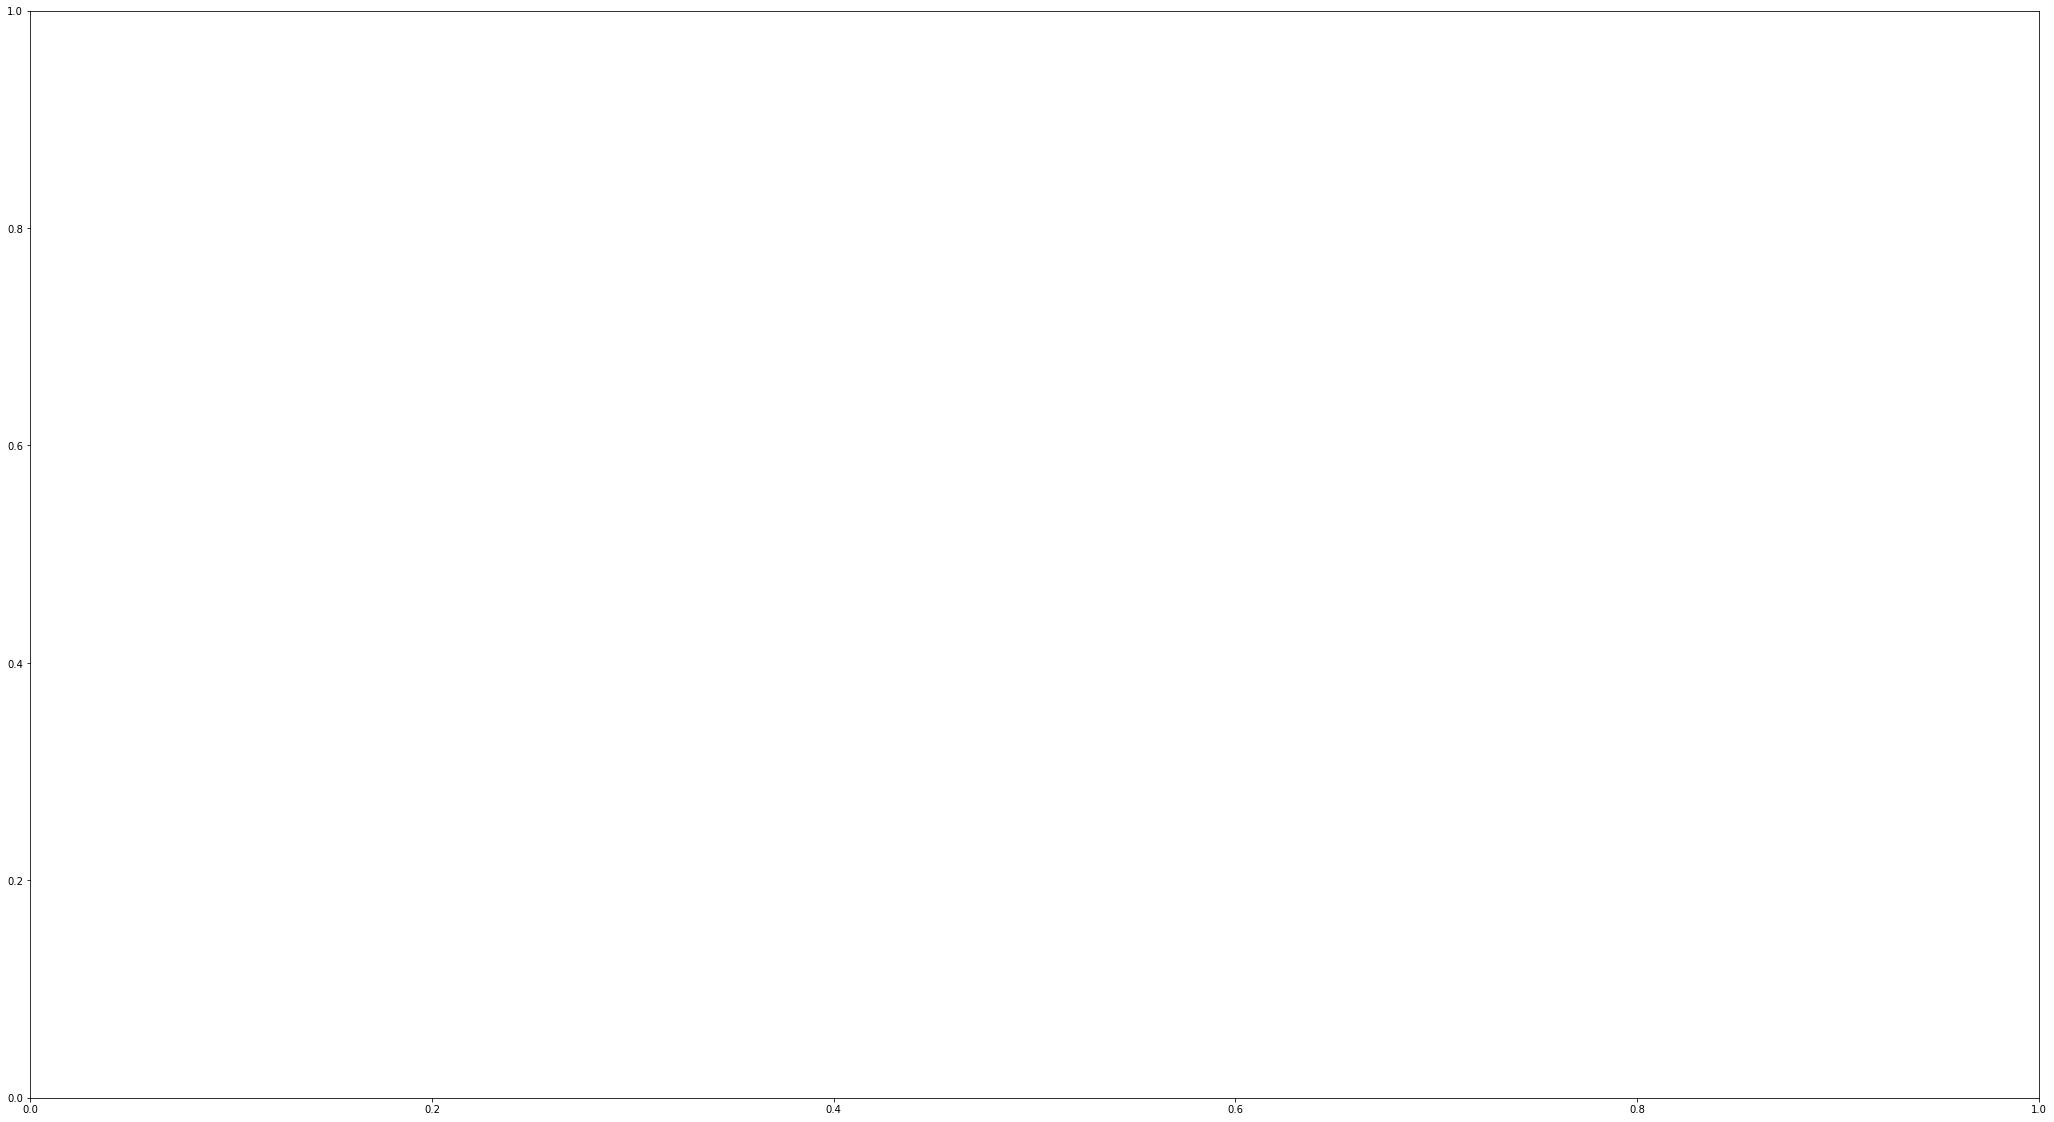

In [96]:
fig, ax = plt.subplots(figsize = (36, 20))

num_of_elements = 8

In [97]:
def draw_barchart(date):

    dummies_frame = dummies[dummies['date'].eq(date)].sort_values(by = ['value'], ascending = True).tail(num_of_elements)
    ax.clear()

    normal_colors = dict(zip(dummies['state'].unique(), rgb_colors_opacity))
    dark_colors = dict(zip(dummies['state'].unique(), rgb_colors_dark))
    
    ax.barh(dummies_frame['state'], dummies_frame['value'], color = [normal_colors[x] for x in dummies_frame['state']], height = 0.8,
            edgecolor =([dark_colors[x] for x in dummies_frame['state']]), linewidth = '6')

    dx = float(dummies_frame['value'].max())

    for i, (values, name) in enumerate(zip(dummies_frame['value'], dummies_frame['state'])):
        ax.text(values + dx, i + (num_of_elements / 50), '    ' + name,
        size = 36, weight = 'bold', ha = 'left', va = 'center', fontdict = {'fontname': 'Trebuchet MS'})
        ax.text(values + dx, i - (num_of_elements / 50), f'    {values:,.0f}', size = 36, ha = 'left', va = 'center')

    time_unit_displayed = re.sub(r'\^(.*)', r'', str(date))
    ax.text(1.0, 1.14, time_unit_displayed, transform = ax.transAxes, color = '#666666',
            size = 62, ha = 'right', weight = 'bold', fontdict = {'fontname': 'Trebuchet MS'})
    ax.text(-0.005, 1.06, 'Cases by State', transform = ax.transAxes, size = 30, color = '#666666')
    ax.text(-0.005, 1.14, 'Total Cases by State', transform = ax.transAxes,
            size = 62, weight = 'bold', ha = 'left', fontdict = {'fontname': 'Trebuchet MS'})

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis = 'x', colors = '#666666', labelsize = 28)
    ax.set_yticks([])
    ax.set_axisbelow(True)
    ax.margins(0, 0.01)
    ax.grid(which = 'major', axis = 'x', linestyle = '-')

    plt.locator_params(axis = 'x', nbins = 4)
    plt.box(False)
    plt.subplots_adjust(left = 0.075, right = 0.75, top = 0.825, bottom = 0.05, wspace = 0.2, hspace = 0.2)

findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.


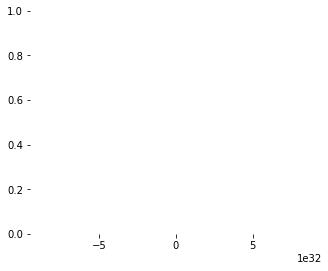

In [98]:
animator = animation.FuncAnimation(fig, draw_barchart, frames = frames_list)
animator.save("Racing Bar Chart.mp4", fps = 20, bitrate = 1800)